## Dependency

In [1]:
%matplotlib inline
from brian2 import *
import numpy as np
import math
from scipy.stats import kstest, norm
import pandas
import seaborn as sns
import statistics as stats
import sys
from IPython.display import clear_output

In [2]:
def chunk_mean(lst,REP):
    # List to store the means
    means = []
    
    # Iterate over the list in steps of 5
    for i in range(0, len(lst), REP):
        # Get the next chunk of 5 elements
        chunk = lst[i:i+REP]
        
        # Calculate the mean if the chunk is not empty
        if chunk:
            mean = sum(chunk) / len(chunk)
            means.append(mean)
    
    return means

def rescale(x_values, l, h, L, H):
    return [((x - l) * (H - L) / (h - l)) + L for x in x_values]

## Results: Random WTA

經過調參之後的結果，以下成功模擬出 gaussian bump 每次試驗因 noise 的影響而於隨機的位置出現之情況，block 1 為單次的結果圖示、block 3 為各個位置 bump 出現次數的累積，以及數次試驗中的成功率。其中，由於不一定每次都會成功出現 WTA (trivial activation 或 saturation, 詳見 parameter tuning section)，因此成功率就是在紀錄數次試驗中成功出現 WTA 的機率。

### Final Initialization

Total mean: 0.4792033475872792
Max: 0.8268702920782488
Width: 16
MAX index: 12


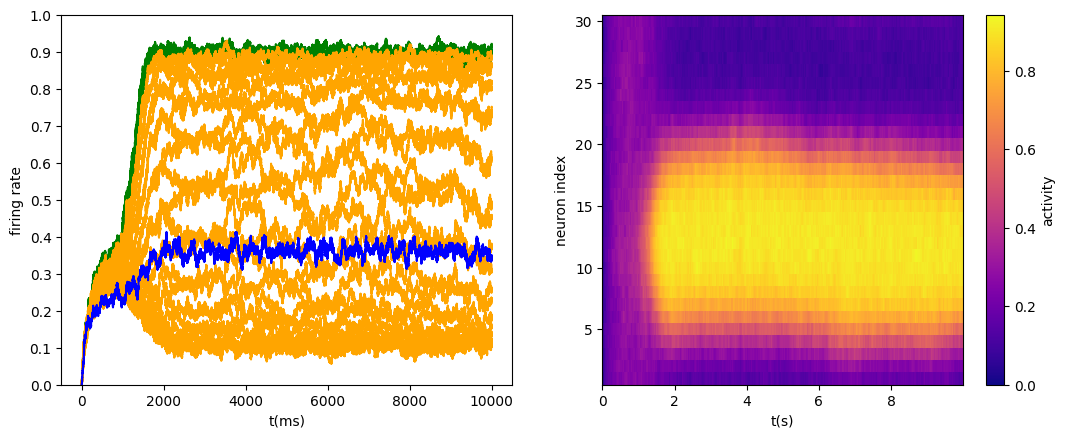

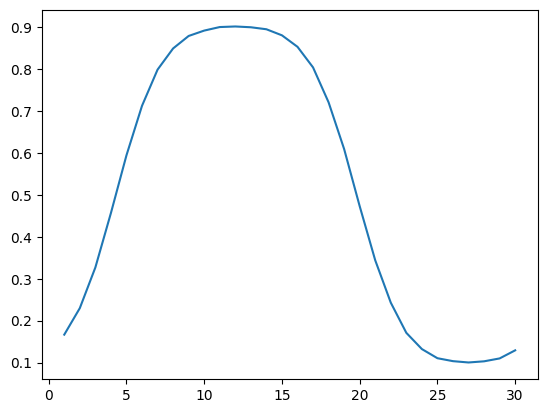

In [7]:
start_scope()


test_set=[]
control=[]
L=2 #local domain
U=L+1

#initial conditions
light=0       ###10^-8


n=31 #num of neurons
jump=2 #spacing

slope=5               
t=46*ms           
threshold=540   
mean=108
std=350       #done

w_I=-380      #354    
w_Eb=20           
w_Ew=284.331 


#simulation
eqs='''
dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
Iin : 1
Isyn : 1
theta : 1
a : 1
sigma : 1
tau : second
mu : 1
'''

G=NeuronGroup(n, eqs, method='euler');


G.r = 0.0
G.tau=t
G.Iin=0
G.Iin[15]=light
G.theta=threshold
G.a=slope
G.mu=mean
G.sigma=std


S = Synapses(G, G, '''
             w : 1 # synaptic weight
             Isyn_post = w * r_pre : 1 (summed)
             ''')

I=[];J=[]
for syn in range(1,n):
    I.append(syn)
    J.append(0)
for syn in range(1,n):
    I.append(0)
    J.append(syn)

for syn in range(1,n):
    if syn < (n-1):
        I.append(syn)
        J.append(syn+1)
    else:
        I.append(syn)
        J.append(1)
if n>3:
    for syn in range(n-1,0,-1):
        if syn>1:
            I.append(syn)
            J.append(syn-1)
        else:
            I.append(syn)
            J.append(n-1)
if n>4:
    for syn in range(1,n):
        if (syn+jump) <= (n-1):
            I.append(syn)
            J.append(syn+jump)
        else:
            I.append(syn)
            J.append(syn-(n-1-jump))
if n>5:
    for syn in range(n-1,0,-1):
        if syn>jump:
            I.append(syn)
            J.append(syn-2)
        else:
            I.append(syn)
            J.append(syn+(n-1-jump))



S.connect(i=I,j=J)

S.w=w_Ew
for syn in np.arange(n-1):
    S.w[syn]=w_Eb

for syn in np.arange(n-1, 2*n-2):
    S.w[syn]=w_I


M = StateMonitor(G, 'r', record=True)

run(10000*ms)

figure(figsize=(12.8,4.8))
subplot(121)
MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1

for i in range(1,31):
    if (MAX-i)<=0:
        if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<0.6:
            width=(i*2)
            break
    else:
        if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<0.6:
            width=(i*2)
            break 

#Winners
winner_id=[]
if MAX<=L:
    for i in range(MAX-L,MAX+U):
        if i <=0:
            plot(M.t/ms, M.r[i+(n-1)], color='green')
            winner_id.append(i+(n-1))
            test_set.append(np.mean( M.r[i+(n-1)]))
        else:
            plot(M.t/ms, M.r[i%(n-1)], color='green')
            winner_id.append(i%(n-1))
            test_set.append(np.mean( M.r[i%(n-1)]))

else:
    for i in range(MAX-L,MAX+U):
        if i == 31:
            plot(M.t/ms, M.r[1], color='green')
            winner_id.append(1)
            test_set.append(np.mean( M.r[i%n]))
        else:
            plot(M.t/ms, M.r[i%n], color='green')
            winner_id.append(i%n)
            test_set.append(np.mean( M.r[i%n]))


#Non-winners
for i in range(1,n):
    if i not in winner_id:
        plot(M.t/ms, M.r[i], color='orange')
        control.append(np.mean(M.r[i]))


plot(M.t/ms, M.r[0], color='blue')
ylim(0,1)
yticks(np.arange(0,1.1,0.1))
xlabel('t(ms)')
ylabel('firing rate')

subplot(122)
neuron_index=range(1,n)
pc=pcolormesh(M.t,neuron_index,M.r[1:31],cmap='plasma', shading='auto');
cbar = colorbar(pc)  # 'pc' is the return value of the pcolormesh call
cbar.set_label('activity')
xlabel('t(s)')
ylabel('neuron index')

print(f'Total mean: {np.mean(M.r[1:n])}')
#print(f'winner mean: {np.mean(test_set)}')
#print(f'loser mean: {np.mean(control)}')
print(f'Max: {np.mean(M.r[MAX])}')
print(f'Width: {width}')

#Distribution check
figure(figsize=(6.4,4.8))
plot(range(1,31),np.mean(M.r[1:,20000:], axis=1));
print(f'MAX index: {MAX}')

### Success Rate check

Success Rate: 1.0


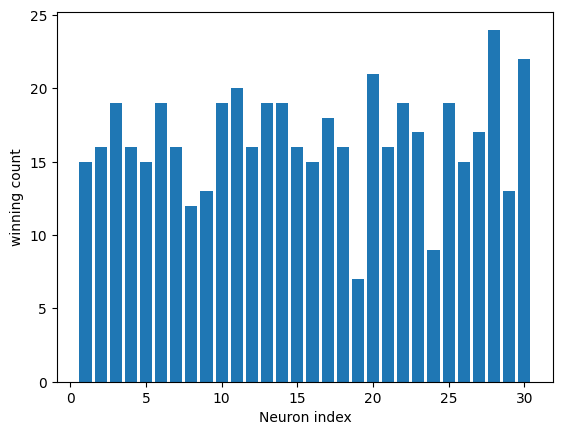

In [8]:
start_scope()

n=31
N_Trial=500

acc=range(N_Trial)
victory_count=np.zeros(n-1)
suc=0
for trial in acc:
    test_set=[]
    control=[]
    L=2 #local domain
    U=L+1

    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms   #53.75        
    threshold=540   
    mean=108
    std=350       #done

    w_I=-380      #354      
    w_Eb=20           
    w_Ew=284.331 #284.331   


    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.Iin[15]=light
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Ew
    for syn in np.arange(n-1):
        S.w[syn]=w_Eb

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_I


    M = StateMonitor(G, 'r', record=True)

    run(3000*ms)
    MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
    if 0.1<np.mean(M.r[:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
        victory_count[MAX-1]+=1
        suc+=1
    print(f'Trial{trial}')
    clear_output(wait=True)

success_rate=round(suc/N_Trial,2)
print(f'Success Rate: {success_rate}');
bar(range(1,n), victory_count);
xlabel('Neuron index');
ylabel('winning count');

## Parameter Tuning


以下分別針對各個參數進行調整，再畫出 target function 隨參數的變化，以及模擬結果的比例統計 (trivial, success, explosion)。

<span style="font-size: 11.5px;">
trivial: 神經元 FR 躺平 <br>
success: 成功出現 WTA dynamic<br>
explosion: 神經元 FR 衝到頂
</span>

### 1. Noise mean looping

In [65]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(90, 132, 2)

for AVGG in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=AVGG
        std=394       #done

        w_I=-350      #      
        w_Eb=20           
        w_Ew=284          #284 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.5 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('noise mean')
ylabel('count')

legend(['explosion','success','trivial']);

show();



Iter 5/Rep 41


### 2. W_I tuning

Iter 70/Rep 50


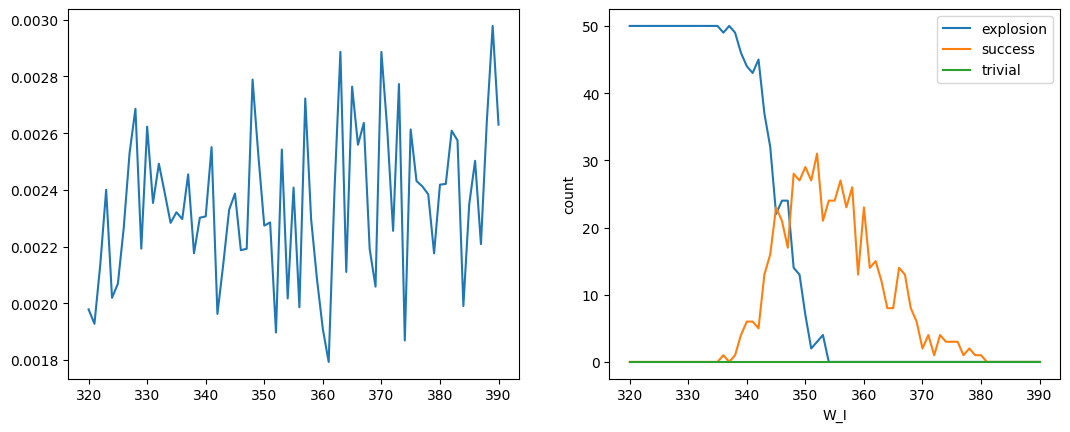

In [ ]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(320, 391, 1)

for WI in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=394       #done

        w_I=-WI      #      
        w_Eb=20           
        w_Ew=284          #284 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.5 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();



$\rightarrow$ Best W_I: -354

### 3. w_Ew Tuning

Iter 13/Rep 50


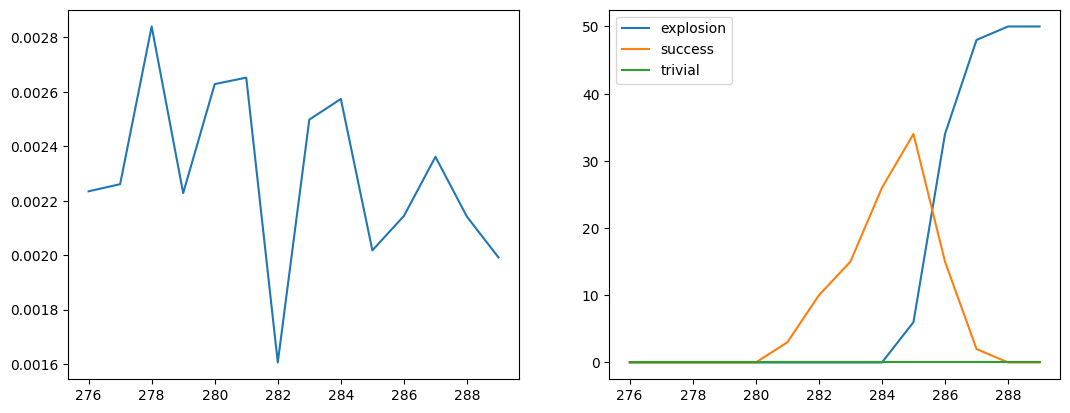

In [ ]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Ref_N=1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(276, 290 , 1)

for WEW in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=394       #done

        w_I=-354      #      
        w_Eb=20           
        w_Ew=WEW          #284  


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.6 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1
        
        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);

legend(['explosion','success','trivial']);

show();

fine inspection

Iter 13/Rep 50


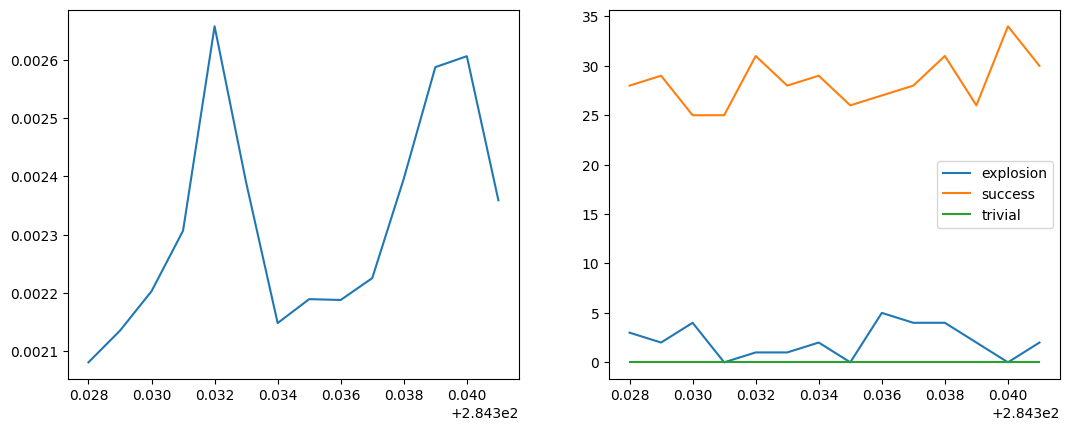

In [ ]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Ref_N=1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(284.328, 284.341 , 0.001)

for WEW in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=394       #done

        w_I=-354      #      
        w_Eb=20           
        w_Ew=WEW          #284  


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.6 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1
        
        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);

legend(['explosion','success','trivial']);

show();

$\rightarrow$ Best w_Ew: 284.331

### 4. Std Tuning

Iter 24/Rep 50


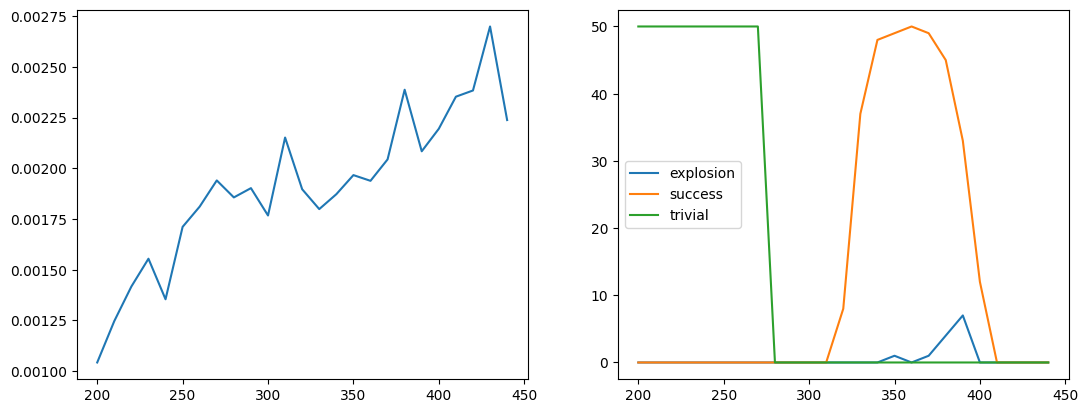

In [5]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Ref_N=1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(200, 450, 10)

for STD in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=STD      

        w_I=-354       
        w_Eb=20           
        w_Ew=284.331 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.5 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1
        
        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);

legend(['explosion','success','trivial']);

show();



-finer inspection

Iter 49/Rep 50


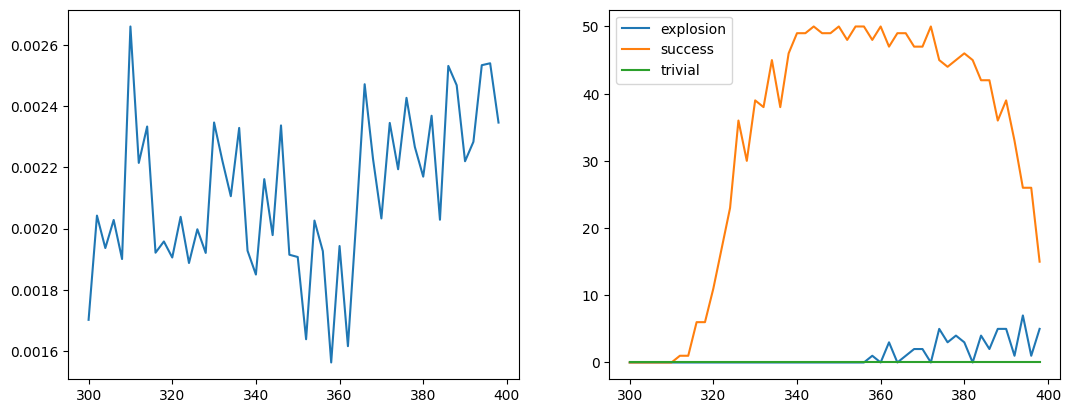

In [6]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Ref_N=1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(300, 400, 2)

for STD in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=STD      

        w_I=-354       
        w_Eb=20           
        w_Ew=284.331 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r)<0.5 and np.mean(M.r[MAX])>0.6: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
                

                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        if MAX==1:
            if np.mean(M.r[n-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[n-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))
        elif MAX==(n-1):
            if np.mean(M.r[MAX-1])>np.mean(M.r[1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[1]))
        else:
            if np.mean(M.r[MAX-1])>np.mean(M.r[MAX+1]):
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX-1]))
            else:
                reptargetf.append(np.mean(M.r[MAX])-np.mean(M.r[MAX+1]))

        repetition+=1
        
        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc,targetf);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);

legend(['explosion','success','trivial']);

show();

$\rightarrow$ ~348

### 二訪w_I

Iter 30/Rep 50


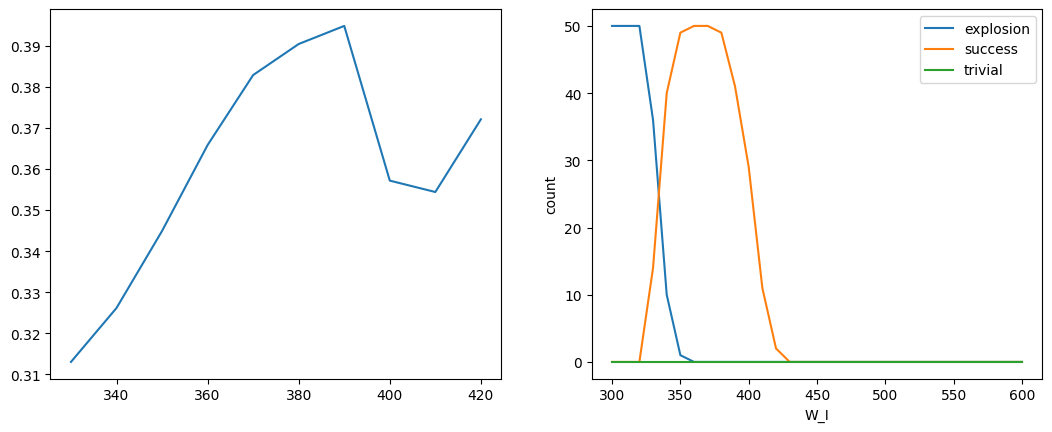

In [34]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(300, 610, 10)

narr=[]
for WI in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    narrowness=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=348       #done

        w_I=-WI      #      
        w_Eb=20           
        w_Ew=284.331 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.1:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                narrowness.append(np.mean(M.r[MAX][20000:])-np.mean(M.r[i][20000:]))
       

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    narr.append(np.mean(narrowness))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



targetf=chunk_mean(reptargetf,REP)
figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, narr);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

## Width as target funtion

### 1. w_I

Iter 23/Rep 50


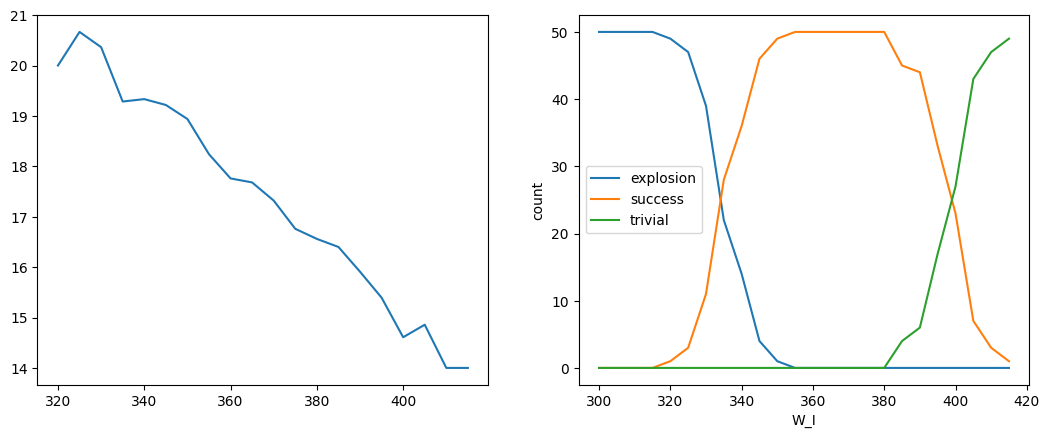

In [50]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(300, 420, 5)

width_avg=[]
for WI in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=348       #done

        w_I=-WI      #      
        w_Eb=20           
        w_Ew=284.331 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break           

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1




figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

$\rightarrow$ w_I=-380

### 2. w_Ew

Iter 41/Rep 50


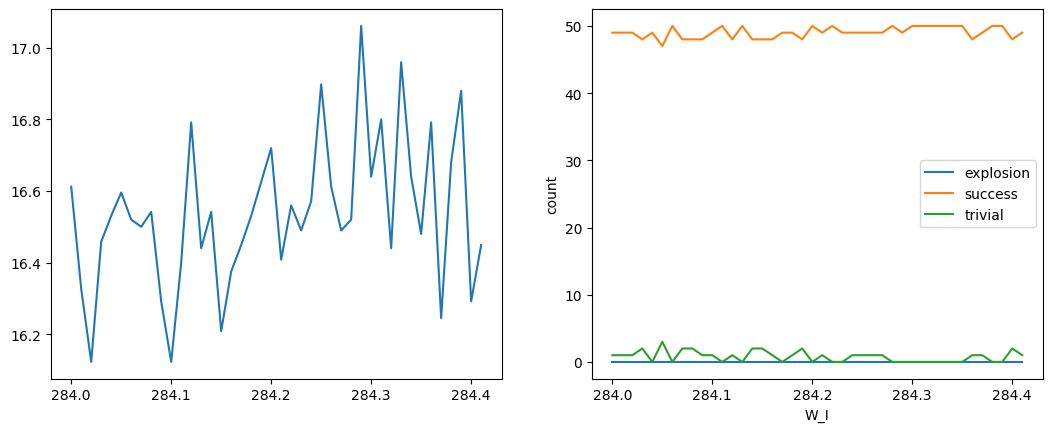

In [57]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(284, 284.41, 0.01)

width_avg=[]
for WEW in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=348       

        w_I=-380            
        w_Eb=20           
        w_Ew=WEW  #284.331


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1




figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

### 3. noise std

Iter 10/Rep 50


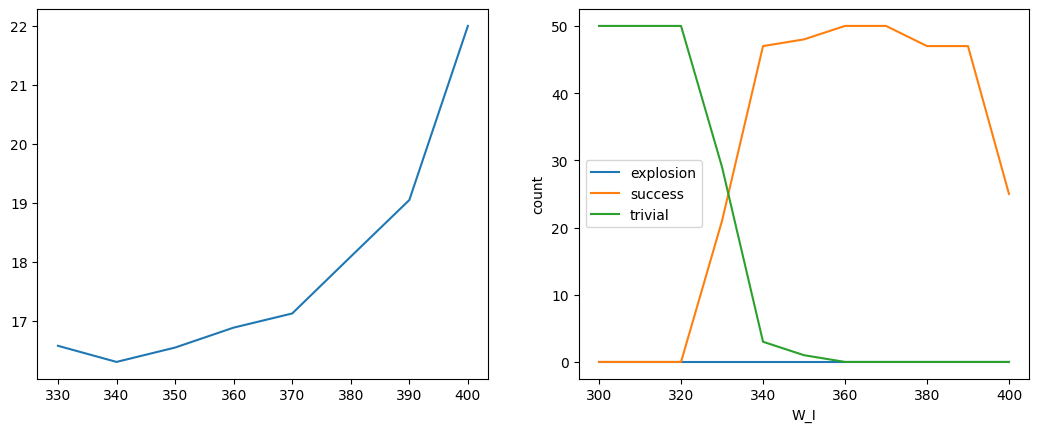

In [60]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(300, 410, 10)

width_avg=[]
for STD in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=108
        std=STD  #348   

        w_I=-380            
        w_Eb=20          
        w_Ew=284
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

$\rightarrow$ 350 

### 4. noise mean

Iter 21/Rep 50


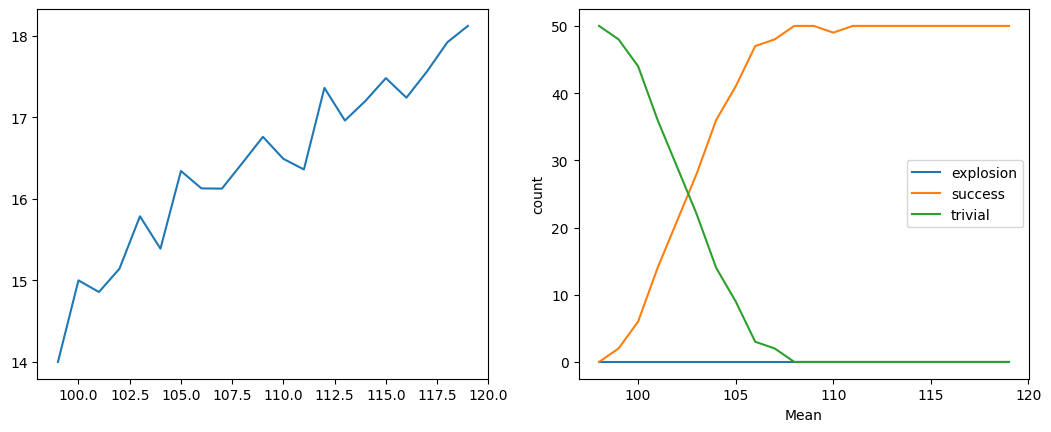

In [71]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(98, 120, 1)

width_avg=[]
for MN in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]
          
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=540   
        mean=MN
        std=350    

        w_I=-380            
        w_Eb=20          
        w_Ew=284
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1
    
        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);

subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('Mean')
ylabel('count')

legend(['explosion','success','trivial']);

show();

$\rightarrow$ 108

### 5. Threshold

Iter 26/Rep 50


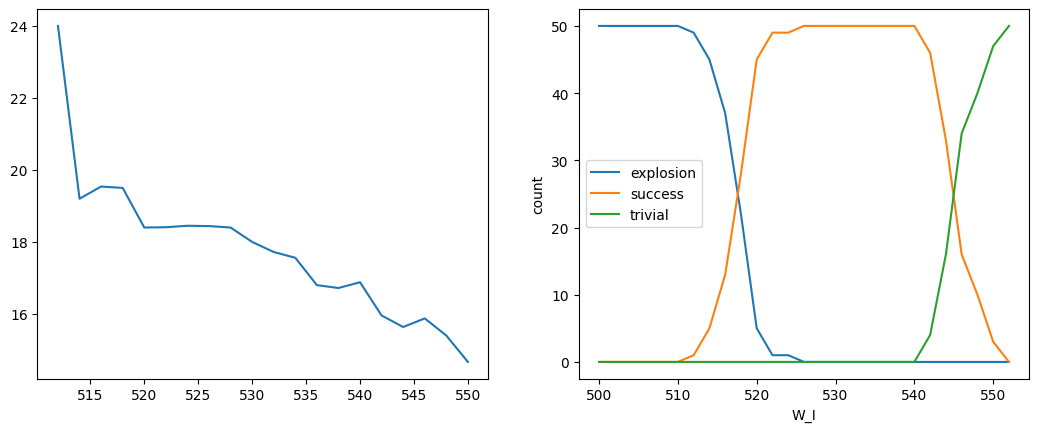

In [76]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(500, 554, 2)

width_avg=[]
for TH in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=50*ms           
        threshold=TH   
        mean=108
        std=350   

        w_I=-380            
        w_Eb=20          
        w_Ew=284
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

$\rightarrow$ 540

### 6. tau

Iter 12/Rep 50


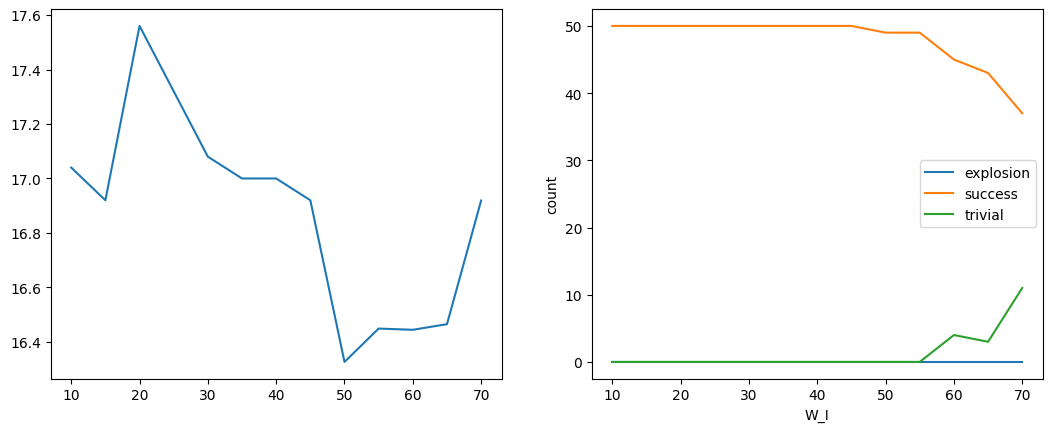

In [85]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(10, 75, 5)

width_avg=[]
for TAU in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=TAU*ms           
        threshold=540   
        mean=108
        std=350   

        w_I=-380            
        w_Eb=20          
        w_Ew=284.331
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

Iter 14/Rep 60


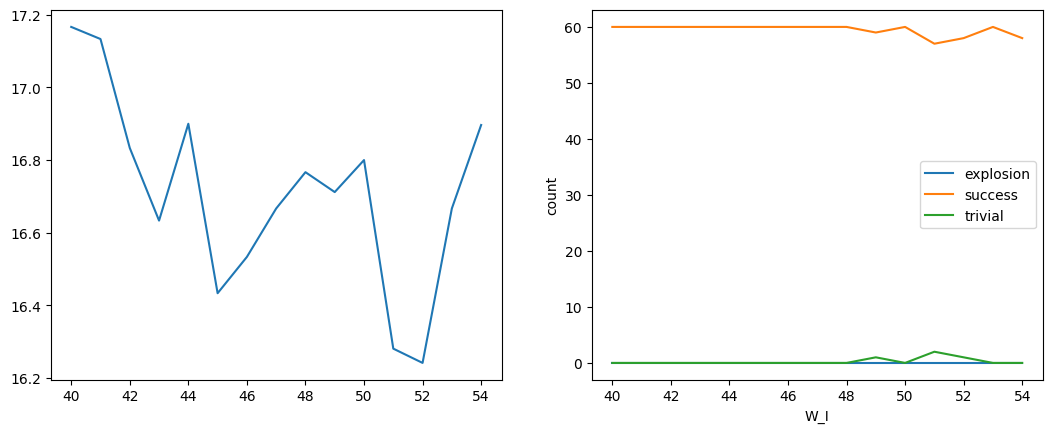

In [99]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=60
acc=np.arange(40, 55, 1)

width_avg=[]
for TAU in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=TAU*ms           
        threshold=540   
        mean=108
        std=350   

        w_I=-380            
        w_Eb=20          
        w_Ew=284.331
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('W_I')
ylabel('count')

legend(['explosion','success','trivial']);

show();

$\rightarrow$ 46

### 7. slope

Iter 18/Rep 50


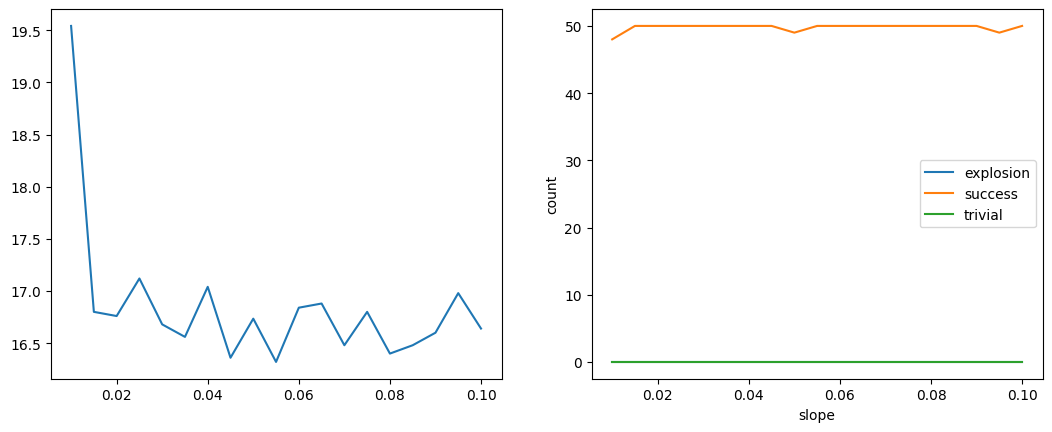

In [13]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(0.01, 0.105, 0.005)

width_avg=[]
for SLP in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=SLP               
        t=46*ms           
        threshold=540   
        mean=108
        std=350   

        w_I=-380            
        w_Eb=20          
        w_Ew=284.331
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('slope')
ylabel('count')

legend(['explosion','success','trivial']);

show();

Iter 74/Rep 50


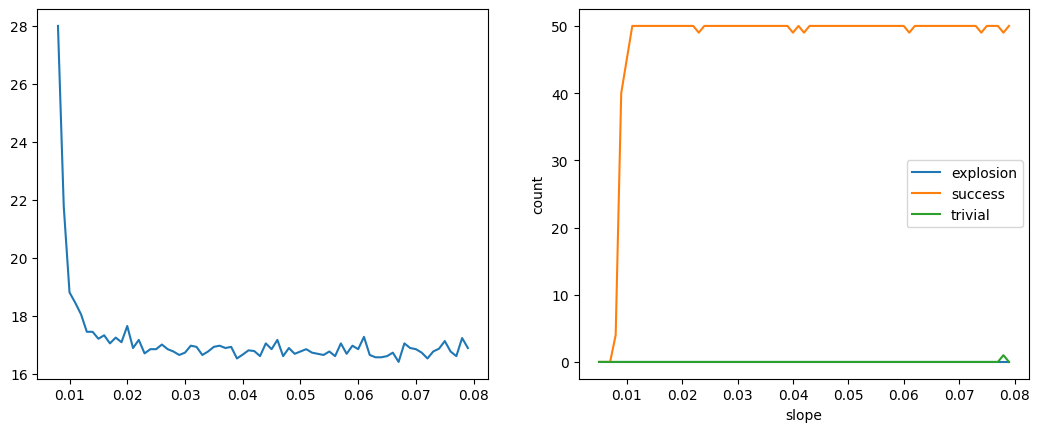

In [15]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
REP=50
acc=np.arange(0.005, 0.080, 0.001)

width_avg=[]
for SLP in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    widths=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0      

        
        n=31 #num of neurons
        jump=2 #spacing

        slope=SLP               
        t=46*ms           
        threshold=540   
        mean=108
        std=350   

        w_I=-380            
        w_Eb=20          
        w_Ew=284.331
        

        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Ew
        for syn in np.arange(n-1):
            S.w[syn]=w_Eb

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_I



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.mean(M.r)>0.5:
            ex+=1
        elif np.mean(M.r)<=0.3:
            tri+=1
        elif 0.1<np.mean(M.r[1:,20000:])<0.68 and np.mean(M.r[MAX][20000:])>0.6: 
            suc+=1
            for i in range(1,31):
                if (MAX-i)<=0:
                    if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break
                else:
                    if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<=0.5:
                        widths.append(i*2)
                        break      

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}')
    
    width_avg.append(np.mean(widths))
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1

figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, width_avg);
subplot(122)
plot(acc,explosion);
plot(acc,success);
plot(acc, trivial);
xlabel('slope')
ylabel('count')

legend(['explosion','success','trivial']);

show();

## Final configuration

$
slope=5 \\              
t=46*ms    \\     
threshold=540   \\
mean=108\\
std=350\\       
w_I=-380\\           
w_{Eb}=20\\           
w_{Ew}=284.331\\  $

success rate: 500/500